In [1]:
import sys
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import imageio
from IPython.display import Image, display
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

from dotenv import load_dotenv
# Load environment variables from .env file
# By default, load_dotenv() looks for .env in the current directory or parent directories.
load_dotenv()

final_stopwords_list = stopwords.words('english') + stopwords.words('french')

# --- Configuration to limit TensorFlow CPU usage ---
threads_count = 8
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# os.environ["TF_NUM_INTEROP_THREADS"] = str(threads_count) # Set number of threads for inter-operation parallelism (across operations)
# os.environ["TF_NUM_INTRAOP_THREADS"] = str(threads_count) # Set number of threads for intra-operation parallelism (within a single operation)
# # This explicitly limits the number of threads for parallel operations.
# tf.config.threading.set_inter_op_parallelism_threads(threads_count)
# tf.config.threading.set_intra_op_parallelism_threads(threads_count)

sys.path.append('../src/functions')
from interpret_gradcam import load_and_preprocess_original_image_for_gradcam, make_gradcam_heatmap, save_and_display_gradcam, superimpose_gradcam_on_image, get_image_full_path

plt.style.use('dark_background')
DATA_PATH = '../data/'

# image_file_extension = 'jpg'
# for BG removed PNG images with transparency
image_file_extension = 'png'
final_model_name = 'Multimodal'

IMAGE_FOLDER_PATH = DATA_PATH + 'images_bgrm/' if image_file_extension == 'png' else DATA_PATH + 'images/'
TRAIN_IMAGE_FOLDER_PATH = IMAGE_FOLDER_PATH + 'image_train/'
TEST_IMAGE_FOLDER_PATH = IMAGE_FOLDER_PATH + 'image_test/'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32 # You can adjust this based on your available CPU memory, larger batch means faster training but more memory usage for current batch.

# DATA_LANGUAGE = 'english'
DATA_LANGUAGE = 'french'
DATA_TEST_LENGTH = 500
# DATA_TEST_LENGTH = 4000
# DATA_TEST_LENGTH = 0 # 0 means full data

# tfidf_max_features = 20000
tfidf_max_features = 10000

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow installation path: {tf.__file__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-07-13 19:56:07.068478: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 19:56:07.087255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752429367.108784  112471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752429367.115153  112471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752429367.133912  112471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
TensorFlow installation path: /home/sameer/anaconda3/envs/rakuten/lib/python3.12/site-packages/tensorflow/__init__.py
Num GPUs Available:  0


In [2]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

try:
    X_train_raw = pd.read_csv(DATA_PATH + 'X_train_update.csv')
    Y_train_raw = pd.read_csv(DATA_PATH + 'Y_train_CVw08PX.csv')
    X_test_raw = pd.read_csv(DATA_PATH + 'X_test_update.csv')

    X_train_raw = X_train_raw.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else X_train_raw
    Y_train_raw = Y_train_raw.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else Y_train_raw
    X_test_raw = X_test_raw.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else X_test_raw

    # Merge training data
    train_df = pd.merge(X_train_raw, Y_train_raw, how='left')

    train_df['description'] = train_df['description'].fillna('')
    X_test_raw['description'] = X_test_raw['description'].fillna('')    
    train_df['designation'] = train_df['designation'].fillna('')
    X_test_raw['designation'] = X_test_raw['designation'].fillna('')
    train_df['text_input'] = train_df['designation'] + ' ' + train_df['description']
    X_test_raw['text_input'] = X_test_raw['designation'] + ' ' + X_test_raw['description']

    # Encode product type codes
    label_encoder = LabelEncoder()
    train_df['prdtypecode_encoded'] = label_encoder.fit_transform(train_df['prdtypecode'])
    num_classes = len(label_encoder.classes_)
    print(f"Number of unique product classes: {num_classes}")

    # Split data for training and validation (stratified to handle imbalance)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        train_df[['productid', 'text_input', 'imageid']], # Features for splitting
        train_df['prdtypecode_encoded'], # Target for splitting
        test_size=0.2,
        random_state=42,
        stratify=train_df['prdtypecode_encoded'] # Essential for class imbalance
    )

    print(f"Train samples: {len(X_train_split)}, Validation samples: {len(X_val_split)}")

except FileNotFoundError:
    print("Error: Ensure CSV files are in the directory.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading or initial processing: {e}")
    exit()

Number of unique product classes: 27
Train samples: 400, Validation samples: 100


In [3]:
# Convert labels to one-hot encoding for Keras models (only if needed by Keras, not Logistic Regression)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_split, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_split, num_classes=num_classes)

print("\n--- Strategy 1: Text-only Traditional ML (using TF-IDF + Logistic Regression) ---")

# --- 1.1. Text Feature Engineering with TF-IDF ---
# Max features to limit memory usage, adjust based on your system
tfidf_vectorizer = TfidfVectorizer(max_features=tfidf_max_features, stop_words=final_stopwords_list, min_df=5, max_df=0.8)
print("Fitting TF-IDF vectorizer on training texts...")
train_tfidf_features = tfidf_vectorizer.fit_transform(X_train_split['text_input'])
print("Transforming validation texts with TF-IDF...")
val_tfidf_features = tfidf_vectorizer.transform(X_val_split['text_input'])
print("Transforming test texts with TF-IDF...")
test_tfidf_features = tfidf_vectorizer.transform(X_test_raw['text_input'])

print(f"Shape of TF-IDF train features: {train_tfidf_features.shape}")

# --- 1.2. Build and Train Text-only Logistic Regression Model ---
print("\nTraining Text-only Logistic Regression Model...")
lr_model = LogisticRegression(max_iter=500, random_state=42, n_jobs=threads_count, verbose=1) # n_jobs=-1 to use all cores
lr_model.fit(train_tfidf_features, y_train_split)

# --- 1.3. Evaluate Text-only Model ---
print("\n--- Evaluating Text-only Logistic Regression Model on Validation Set ---")
text_val_preds = lr_model.predict(val_tfidf_features)

print(classification_report(y_val_split, text_val_preds, labels=np.arange(num_classes), target_names=label_encoder.classes_.astype(str), zero_division=0))
text_f1_macro = f1_score(y_val_split, text_val_preds, average='macro', zero_division=0)
print(f"Text-only Logistic Regression Macro F1 Score on Validation Set: {text_f1_macro:.4f}")


--- Strategy 1: Text-only Traditional ML (using TF-IDF + Logistic Regression) ---
Fitting TF-IDF vectorizer on training texts...
Transforming validation texts with TF-IDF...
Transforming test texts with TF-IDF...
Shape of TF-IDF train features: (400, 718)

Training Text-only Logistic Regression Model...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        19413     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29584D+00    |proj g|=  6.54630D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
19413     23     25      1     0     0   5.803D-05   2.379D+00
  F =   2.3787599560920092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

--- Evaluating Text-only Logistic Regression Model on Validation Set ---
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         3
          4

 This problem is unconstrained.


In [4]:
# --- Strategy 2: Multimodal Deep Learning (TF-IDF + Image Features) ---
print("\n--- Strategy 2: Multimodal Deep Learning (TF-IDF + Image Features) ---")
# --- 2.1. Image Feature Extraction (Using a pre-trained CNN) ---
# Load a pre-trained CNN for feature extraction
base_image_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_image_model.trainable = False # Freeze the base model to use it as a feature extractor

# Create a Keras model for RGB feature extraction (CNN + Pooling)
# This model will be used inside the tf.data.Dataset.map function

# 1. RGB Feature Extractor (MobileNetV2 + GlobalAveragePooling2D)
# This takes the RGB image and outputs the pooled MobileNetV2 features
rgb_feature_extractor_model = tf.keras.Sequential([
    base_image_model,
    tf.keras.layers.GlobalAveragePooling2D()
], name='rgb_feature_extractor_model')
rgb_feature_extractor_model.trainable = False # Ensure it's frozen

# 2. Alpha Feature Extractor (just GlobalAveragePooling2D on the single channel)
# It needs a known input shape for building. IMAGE_SIZE[0], IMAGE_SIZE[1] for H, W, and 1 for channel
alpha_feature_extractor_model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
], name='alpha_feature_extractor_model')

print("RGB Feature Extractor Summary:")
rgb_feature_extractor_model.summary()
print("\nAlpha Feature Extractor Summary:")
alpha_feature_extractor_model.summary()

def load_and_preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(IMAGE_SIZE)
        img_array = np.array(img).astype('float32') / 255.0
        # print(f"Success: Image found at {image_path}")
        return img_array
    except FileNotFoundError:
        print(f"Warning: Image not found at {image_path}. Returning a dummy black image.")
        return np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.float32) # Return black dummy image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}. Returning a dummy black image.")
        return np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.float32)

        # Split into R, G, B, A
        r, g, b, a = rgba_img.split()

        # Convert RGB part to numpy array and normalize
        rgb_img_array = np.array(Image.merge('RGB', (r, g, b))).astype('float32') / 255.0

        # Convert Alpha part to numpy array and normalize
        alpha_channel_array = np.array(a).astype('float32') / 255.0
        # Ensure alpha has a channel dimension (H, W, 1) for consistency in Keras layers
        alpha_channel_array = np.expand_dims(alpha_channel_array, axis=-1)
        # print(f"Success: Image found at {image_path}")
        return rgb_img_array, alpha_channel_array
    except FileNotFoundError:
        print(f"Warning: Image not found at {image_path}. Returning dummy RGB and Alpha.")
        return (np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.float32),
                np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.float32))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}. Returning dummy RGB and Alpha.")
        return (np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.float32),
                np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.float32))

def get_image_full_path(image_id, product_id, base_folder, file_extension = image_file_extension):
    return os.path.join(base_folder, f'image_{image_id}_product_{product_id}.{file_extension}')


--- Strategy 2: Multimodal Deep Learning (TF-IDF + Image Features) ---
RGB Feature Extractor Summary:


/home/sameer/anaconda3/envs/rakuten/lib/python3.12/site-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "rgb_feature_extractor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Alpha Feature Extractor Summary:


Model: "alpha_feature_extractor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_1      │ (None, 1)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Generator for training data (now yields features directly)
def train_data_generator(): # Renamed from _pre_extracted for simplicity
    for i in range(len(X_train_split)): # Iterate by numerical index
        tfidf_vec = train_tfidf_features[i].toarray().squeeze()
        label = y_train_one_hot[i]
        rgb_feat = loaded_train_rgb_features[i]
        alpha_feat = loaded_train_alpha_features[i]
        yield (rgb_feat, alpha_feat, tfidf_vec, label)

# Generator for validation data (now yields features directly)
def val_data_generator(): # Renamed from _pre_extracted for simplicity
    for i in range(len(X_val_split)): # Iterate by numerical index
        tfidf_vec = val_tfidf_features[i].toarray().squeeze()
        label = y_val_one_hot[i]
        rgb_feat = loaded_val_rgb_features[i]
        alpha_feat = loaded_val_alpha_features[i]
        yield (rgb_feat, alpha_feat, tfidf_vec, label)

# Generator for test data (now yields features directly)
def test_data_generator(): # Renamed from _pre_extracted for simplicity
    for i in range(len(X_test_raw)): # Iterate by numerical index
        tfidf_vec = test_tfidf_features[i].toarray().squeeze()
        rgb_feat = loaded_test_rgb_features[i]
        alpha_feat = loaded_test_alpha_features[i]
        yield (rgb_feat, alpha_feat, tfidf_vec) # No label for test set

# --- Helper for generating image paths only for feature extraction ---
def image_path_generator_for_extraction(dataframe, image_folder_path):
    for i, row in dataframe.iterrows():
        product_id = row['productid']
        image_id = row['imageid']
        image_path = get_image_full_path(image_id, product_id, image_folder_path)
        yield image_path

# --- Map function for loading raw images from paths for feature extraction ---
# This will decode and resize, but NOT run the CNN
@tf.function
def load_and_preprocess_raw_image_for_extraction(image_path):
    img_raw = tf.io.read_file(image_path)
    img_decoded = tf.image.decode_image(img_raw, channels=4, expand_animations=False)
    img_resized = tf.image.resize(img_decoded, IMAGE_SIZE)
    img_resized = tf.cast(img_resized, tf.float32) / 255.0 # Normalize pixel values
    rgb_image = img_resized[:, :, :3]
    alpha_channel = img_resized[:, :, 3:]
    return rgb_image, alpha_channel

@tf.function # Decorator for performance (compiles into a TensorFlow graph)
def load_and_preprocess_image_rgba_tf(image_path, tfidf_vector, label_one_hot):
    # Read and decode the image
    img_raw = tf.io.read_file(image_path)
    # Decode image as 4 channels. If it's RGB (3 channels), tf.image.decode_image will handle it,
    # and the 4th channel (alpha_channel) will effectively be zeros or handled by the pooling.
    img_decoded = tf.image.decode_image(img_raw, channels=4, expand_animations=False)
    img_resized = tf.image.resize(img_decoded, IMAGE_SIZE)
    img_resized = tf.cast(img_resized, tf.float32) / 255.0 # Normalize

    # Split into RGB and Alpha channels
    rgb_image = img_resized[:, :, :3]  # First 3 channels for RGB
    alpha_channel = img_resized[:, :, 3:] # Last channel for Alpha (H, W, 1)

    # --- Crucial Changes: Apply feature extraction within the map function ---

    # Add a batch dimension to the single image to pass it through the Keras model
    rgb_image_batched = tf.expand_dims(rgb_image, axis=0)
    # Extract RGB features using the pre-defined feature extractor model
    rgb_features_pooled = rgb_feature_extractor(rgb_image_batched) # Output will be (1, 1280)
    rgb_features_pooled = tf.squeeze(rgb_features_pooled, axis=0) # Remove batch dimension (1280,)

    # Add a batch dimension to the alpha channel to pass it through GlobalAveragePooling2D
    alpha_channel_batched = tf.expand_dims(alpha_channel, axis=0)
    # Pool Alpha channel features (output will be (1, 1))
    alpha_features_pooled = GlobalAveragePooling2D()(alpha_channel_batched)
    alpha_features_pooled = tf.squeeze(alpha_features_pooled, axis=0) # Remove batch dimension (1,)

    # Prepare inputs dictionary for the multimodal model
    inputs = {
        'text_input_multi_tfidf': tfidf_vector,
        'image_input_multi_rgb': rgb_features_pooled,
        'alpha_input_multi': alpha_features_pooled
    }

    return inputs, label_one_hot

# Create test dataset for predictions
# Note: For prediction, load_and_preprocess_image_rgba_tf needs to return just the inputs
# So, we need a slightly modified mapping function for the test set
@tf.function
def load_and_preprocess_image_rgba_tf_test(image_path, tfidf_vector):
    img_raw = tf.io.read_file(image_path)
    img_decoded = tf.image.decode_image(img_raw, channels=4, expand_animations=False)
    img_resized = tf.image.resize(img_decoded, IMAGE_SIZE)
    img_resized = tf.cast(img_resized, tf.float32) / 255.0

    rgb_image = img_resized[:, :, :3]
    alpha_channel = img_resized[:, :, 3:]

    # Add a batch dimension, extract features, and squeeze
    rgb_image_batched = tf.expand_dims(rgb_image, axis=0)
    rgb_features_pooled = rgb_feature_extractor(rgb_image_batched)
    rgb_features_pooled = tf.squeeze(rgb_features_pooled, axis=0)

    alpha_channel_batched = tf.expand_dims(alpha_channel, axis=0)
    alpha_features_pooled = GlobalAveragePooling2D()(alpha_channel_batched)
    alpha_features_pooled = tf.squeeze(alpha_features_pooled, axis=0)

    inputs = {
        'text_input_multi_tfidf': tfidf_vector,
        'image_input_multi_rgb': rgb_features_pooled,
        'alpha_input_multi': alpha_features_pooled
    }
    return inputs

# --- Simplified Mapping Function for Pre-extracted Features ---
# This function just combines the loaded features into the model's input dictionary
@tf.function
def combine_pre_extracted_features_tf(rgb_feat, alpha_feat, tfidf_vector, label=None):
    inputs = {
        'text_input_multi_tfidf': tfidf_vector,
        'image_input_multi_rgb': rgb_feat,
        'alpha_input_multi': alpha_feat
    }
    if label is not None:
        return inputs, label
    else:
        return inputs # For test set where no label is present

In [6]:
# --- Create temporary datasets for feature extraction ---
print("Creating temporary datasets for raw image extraction...")

# Train Set Raw Image Dataset
raw_train_image_dataset = tf.data.Dataset.from_generator(
    lambda: image_path_generator_for_extraction(X_train_split, TRAIN_IMAGE_FOLDER_PATH),
    output_signature=tf.TensorSpec(dtype=tf.string, shape=())
)
raw_train_image_dataset = raw_train_image_dataset.map(
    load_and_preprocess_raw_image_for_extraction, num_parallel_calls=tf.data.AUTOTUNE
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Set Raw Image Dataset
raw_val_image_dataset = tf.data.Dataset.from_generator(
    lambda: image_path_generator_for_extraction(X_val_split, TRAIN_IMAGE_FOLDER_PATH), # Assuming val images are in TRAIN_IMAGE_FOLDER_PATH
    output_signature=tf.TensorSpec(dtype=tf.string, shape=())
)
raw_val_image_dataset = raw_val_image_dataset.map(
    load_and_preprocess_raw_image_for_extraction, num_parallel_calls=tf.data.AUTOTUNE
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test Set Raw Image Dataset
raw_test_image_dataset = tf.data.Dataset.from_generator(
    lambda: image_path_generator_for_extraction(X_test_raw, TEST_IMAGE_FOLDER_PATH), # Assuming test images are in TEST_IMAGE_FOLDER_PATH
    output_signature=tf.TensorSpec(dtype=tf.string, shape=())
)
raw_test_image_dataset = raw_test_image_dataset.map(
    load_and_preprocess_raw_image_for_extraction, num_parallel_calls=tf.data.AUTOTUNE
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Temporary datasets created for raw image processing.")

Creating temporary datasets for raw image extraction...
Temporary datasets created for raw image processing.


In [7]:
# --- Feature Extraction and Saving ---
OUTPUT_FEATURES_DIR = './pre_extracted_features' # Directory to save features
os.makedirs(OUTPUT_FEATURES_DIR, exist_ok=True) # Create directory if it doesn't exist

print("\n--- Extracting and Saving Training Features ---")
all_train_rgb_features = []
all_train_alpha_features = []
for rgb_batch, alpha_batch in tqdm(raw_train_image_dataset, desc="Extracting train features"):
    # Use .numpy() to convert eager tensors to numpy arrays
    # verbose=0 suppresses predict's progress bar, tqdm provides one.
    all_train_rgb_features.append(rgb_feature_extractor_model.predict(rgb_batch, verbose=0))
    all_train_alpha_features.append(alpha_feature_extractor_model.predict(alpha_batch, verbose=0))

train_rgb_features_array = np.vstack(all_train_rgb_features)
train_alpha_features_array = np.vstack(all_train_alpha_features)
np.save(os.path.join(OUTPUT_FEATURES_DIR, 'train_rgb_features.npy'), train_rgb_features_array)
np.save(os.path.join(OUTPUT_FEATURES_DIR, 'train_alpha_features.npy'), train_alpha_features_array)
print(f"Train RGB features shape: {train_rgb_features_array.shape}, Alpha features shape: {train_alpha_features_array.shape}")
print(f"Saved to {OUTPUT_FEATURES_DIR}/train_rgb_features.npy and train_alpha_features.npy")


print("\n--- Extracting and Saving Validation Features ---")
all_val_rgb_features = []
all_val_alpha_features = []
for rgb_batch, alpha_batch in tqdm(raw_val_image_dataset, desc="Extracting val features"):
    all_val_rgb_features.append(rgb_feature_extractor_model.predict(rgb_batch, verbose=0))
    all_val_alpha_features.append(alpha_feature_extractor_model.predict(alpha_batch, verbose=0))

val_rgb_features_array = np.vstack(all_val_rgb_features)
val_alpha_features_array = np.vstack(all_val_alpha_features)
np.save(os.path.join(OUTPUT_FEATURES_DIR, 'val_rgb_features.npy'), val_rgb_features_array)
np.save(os.path.join(OUTPUT_FEATURES_DIR, 'val_alpha_features.npy'), val_alpha_features_array)
print(f"Validation RGB features shape: {val_rgb_features_array.shape}, Alpha features shape: {val_alpha_features_array.shape}")
print(f"Saved to {OUTPUT_FEATURES_DIR}/val_rgb_features.npy and val_alpha_features.npy")


print("\n--- Extracting and Saving Test Features ---")
all_test_rgb_features = []
all_test_alpha_features = []
for rgb_batch, alpha_batch in tqdm(raw_test_image_dataset, desc="Extracting test features"):
    all_test_rgb_features.append(rgb_feature_extractor_model.predict(rgb_batch, verbose=0))
    all_test_alpha_features.append(alpha_feature_extractor_model.predict(alpha_batch, verbose=0))

test_rgb_features_array = np.vstack(all_test_rgb_features)
test_alpha_features_array = np.vstack(all_test_alpha_features)
np.save(os.path.join(OUTPUT_FEATURES_DIR, 'test_rgb_features.npy'), test_rgb_features_array)
np.save(os.path.join(OUTPUT_FEATURES_DIR, 'test_alpha_features.npy'), test_alpha_features_array)
print(f"Test RGB features shape: {test_rgb_features_array.shape}, Alpha features shape: {test_alpha_features_array.shape}")
print(f"Saved to {OUTPUT_FEATURES_DIR}/test_rgb_features.npy and test_alpha_features.npy")

print("\nFeature extraction complete for all datasets!")


--- Extracting and Saving Training Features ---


Extracting train features: 0it [00:00, ?it/s]

Train RGB features shape: (400, 1280), Alpha features shape: (400, 1)
Saved to ./pre_extracted_features/train_rgb_features.npy and train_alpha_features.npy

--- Extracting and Saving Validation Features ---


2025-07-13 19:56:30.101454: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Extracting val features: 0it [00:00, ?it/s]

Validation RGB features shape: (100, 1280), Alpha features shape: (100, 1)
Saved to ./pre_extracted_features/val_rgb_features.npy and val_alpha_features.npy

--- Extracting and Saving Test Features ---


2025-07-13 19:56:32.526402: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Extracting test features: 0it [00:00, ?it/s]

Test RGB features shape: (500, 1280), Alpha features shape: (500, 1)
Saved to ./pre_extracted_features/test_rgb_features.npy and test_alpha_features.npy

Feature extraction complete for all datasets!


In [8]:
# --- Load Pre-extracted Features ---
# Make sure OUTPUT_FEATURES_DIR is defined as in Step 1.3
OUTPUT_FEATURES_DIR = './pre_extracted_features'

print("\n--- Loading pre-extracted features ---")
loaded_train_rgb_features = np.load(os.path.join(OUTPUT_FEATURES_DIR, 'train_rgb_features.npy'))
loaded_train_alpha_features = np.load(os.path.join(OUTPUT_FEATURES_DIR, 'train_alpha_features.npy'))
loaded_val_rgb_features = np.load(os.path.join(OUTPUT_FEATURES_DIR, 'val_rgb_features.npy'))
loaded_val_alpha_features = np.load(os.path.join(OUTPUT_FEATURES_DIR, 'val_alpha_features.npy'))
loaded_test_rgb_features = np.load(os.path.join(OUTPUT_FEATURES_DIR, 'test_rgb_features.npy'))
loaded_test_alpha_features = np.load(os.path.join(OUTPUT_FEATURES_DIR, 'test_alpha_features.npy'))

print("Features loaded successfully.")


--- Loading pre-extracted features ---
Features loaded successfully.


In [9]:
# --- Recreate tf.data.Dataset Objects with Pre-extracted Features ---
print("\n--- Recreating tf.data.Dataset objects with pre-extracted features ---")

# Define output signatures for the new generators and map function
# These shapes should match the output of your feature extractors and TF-IDF
# For MobileNetV2 GlobalAveragePooling2D, the output shape is (1280,)
# For Alpha GlobalAveragePooling2D, the output shape is (1,)
output_signature_train_val = (
    tf.TensorSpec(dtype=tf.float32, shape=(1280,)), # RGB feature shape
    tf.TensorSpec(dtype=tf.float32, shape=(1,)),    # Alpha feature shape
    tf.TensorSpec(dtype=tf.float32, shape=(train_tfidf_features.shape[1],)), # TFIDF shape
    tf.TensorSpec(dtype=tf.float32, shape=(num_classes,)) # Label shape
)

output_signature_test = (
    tf.TensorSpec(dtype=tf.float32, shape=(1280,)),
    tf.TensorSpec(dtype=tf.float32, shape=(1,)),
    tf.TensorSpec(dtype=tf.float32, shape=(test_tfidf_features.shape[1],))
)

# Create training dataset
train_dataset = tf.data.Dataset.from_generator(
    train_data_generator, # Use the redefined generator
    output_signature=output_signature_train_val
)
train_dataset = train_dataset.map(combine_pre_extracted_features_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()


# Create validation dataset
val_dataset = tf.data.Dataset.from_generator(
    val_data_generator, # Use the redefined generator
    output_signature=output_signature_train_val
)
val_dataset = val_dataset.map(combine_pre_extracted_features_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()


# Create test dataset for predictions
test_dataset = tf.data.Dataset.from_generator(
    test_data_generator, # Use the redefined generator
    output_signature=output_signature_test
)
# For test_dataset, the map function needs to be explicitly told no label is expected
test_dataset = test_dataset.map(lambda r, a, t: combine_pre_extracted_features_tf(r, a, t, label=None), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("New datasets created using pre-extracted features.")
print("Example element spec for train_dataset (should show features and label):")
print(train_dataset.element_spec)


--- Recreating tf.data.Dataset objects with pre-extracted features ---
New datasets created using pre-extracted features.
Example element spec for train_dataset (should show features and label):
({'text_input_multi_tfidf': TensorSpec(shape=(None, 718), dtype=tf.float32, name=None), 'image_input_multi_rgb': TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), 'alpha_input_multi': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 27), dtype=tf.float32, name=None))


In [10]:
# Function to get image embeddings (batch processing for efficiency)
def get_image_embeddings(df_subset, image_folder_path, base_cnn_model, batch_size=32):
    image_data_list = df_subset[['imageid', 'productid']].values.tolist()
    image_paths = [get_image_full_path(img_id, prod_id, image_folder_path) for img_id, prod_id in image_data_list]
    
    processed_images_list = []
    print(f"Loading and preprocessing {len(image_paths)} images...")
    for path in tqdm(image_paths, desc="Image Loading/Preproc"):
        processed_images_list.append(load_and_preprocess_image(path))
            
    all_image_arrays = np.array(processed_images_list)
    print("Extracting image features using CNN...")
    image_features = base_cnn_model.predict(all_image_arrays, batch_size=batch_size, verbose=0)    
    image_features_pooled = GlobalAveragePooling2D()(tf.convert_to_tensor(image_features))
    
    return image_features_pooled.numpy()

print("Generating image features for train, val and test sets (this will take time and memory)...")
train_image_features = get_image_embeddings(X_train_split, TRAIN_IMAGE_FOLDER_PATH, base_image_model)
val_image_features = get_image_embeddings(X_val_split, TRAIN_IMAGE_FOLDER_PATH, base_image_model)
test_image_features = get_image_embeddings(X_test_raw, TEST_IMAGE_FOLDER_PATH, base_image_model)

print(f"Shape of extracted train image features: {train_image_features.shape}")

Generating image features for train, val and test sets (this will take time and memory)...
Loading and preprocessing 400 images...


Image Loading/Preproc:   0%|          | 0/400 [00:00<?, ?it/s]

Extracting image features using CNN...
Loading and preprocessing 100 images...


Image Loading/Preproc:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting image features using CNN...
Loading and preprocessing 500 images...


Image Loading/Preproc:   0%|          | 0/500 [00:00<?, ?it/s]

Extracting image features using CNN...
Shape of extracted train image features: (400, 1280)


In [11]:
# Input for TF-IDF text features
# TF-IDF features are sparse, so convert to dense for Keras Input Layer
# Use train_tfidf_features.shape[1] for the input dimension
text_input_multi_tfidf = Input(shape=(train_tfidf_features.shape[1],), dtype=tf.float32, name='text_input_multi_tfidf')

# Dense layer to process TF-IDF features and make them compatible for concatenation
x_text = Dense(256, activation='relu')(text_input_multi_tfidf) # Reduce dimensionality
x_text = Dropout(0.3)(x_text)

In [12]:
# --- 2.2. Build Multimodal Deep Learning Model (TF-IDF + RGB + Alpha Image Features Fusion) ---
if image_file_extension == 'png':
    # Input for RGB Image Features
    image_input_multi_rgb = Input(shape=(loaded_train_rgb_features.shape[1],), name='image_input_multi_rgb')
    
    # Input for Alpha Channel Features (NEW input branch)
    # The shape will be (1,) as it's the result of GlobalAveragePooling2D on (H,W,1)
    alpha_input_multi = Input(shape=(loaded_train_alpha_features.shape[1],), name='alpha_input_multi')
    x_alpha = Dense(32, activation='relu')(alpha_input_multi) # Small dense layer for alpha
    x_alpha = Dropout(0.2)(x_alpha)
    
    # Concatenate text, RGB image features, and Alpha features
    concatenated_features_multi = Concatenate()([x_text, image_input_multi_rgb, x_alpha])
    
    # Add dense layers for classification on combined features
    x_multi = Dropout(0.3)(concatenated_features_multi)
    x_multi = Dense(512, activation='relu')(x_multi)
    x_multi = Dropout(0.3)(x_multi)
    output_multi = Dense(num_classes, activation='softmax', name='multimodal_output')(x_multi)
    
    # Multimodal model now takes 3 inputs
    multimodal_model = Model(inputs=[text_input_multi_tfidf, image_input_multi_rgb, alpha_input_multi], outputs=output_multi, name='multimodal_model')

In [13]:
# --- 2.2. Build Multimodal Deep Learning Model (TF-IDF + Image Features Fusion) ---
if image_file_extension != 'png':    
    # Input for Image Features
    image_input_multi = Input(shape=(train_image_features.shape[1],), name='image_input_multi')
    # Concatenate text and image features
    concatenated_features_multi = Concatenate()([x_text, image_input_multi])
    
    # Add dense layers for classification on combined features
    x_multi = Dropout(0.3)(concatenated_features_multi)
    x_multi = Dense(512, activation='relu')(x_multi)
    x_multi = Dropout(0.3)(x_multi)
    output_multi = Dense(num_classes, activation='softmax', name='multimodal_output')(x_multi)
    multimodal_model = Model(inputs=[text_input_multi_tfidf, image_input_multi], outputs=output_multi, name='multimodal_model')

In [14]:
# Compile the multimodal model
optimizer_multi = Adam(learning_rate=1e-4) # Slightly higher LR for simpler models
loss_fn_multi = tf.keras.losses.CategoricalCrossentropy()
metrics_multi = ['accuracy']
multimodal_model.compile(optimizer=optimizer_multi, loss=loss_fn_multi, metrics=metrics_multi)

early_stopping_multi = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_multi = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

In [15]:
if image_file_extension == 'png':    
    # --- Calculate steps_per_epoch and validation_steps (still necessary) ---
    num_train_samples = len(X_train_split)
    steps_per_epoch = num_train_samples // BATCH_SIZE
    if num_train_samples % BATCH_SIZE != 0:
        steps_per_epoch += 1
    
    num_val_samples = len(X_val_split)
    validation_steps = num_val_samples // BATCH_SIZE
    if num_val_samples % BATCH_SIZE != 0:
        validation_steps += 1
    
    print(f"\nCalculated steps_per_epoch: {steps_per_epoch}")
    print(f"Calculated validation_steps: {validation_steps}")
    
    # --- Train your Multimodal Model ---
    print("\nTraining Multimodal Model (with pre-extracted features)...")
    history_multimodal = multimodal_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10, # Or your desired number of epochs
        steps_per_epoch=steps_per_epoch,       # <--- THIS IS CRUCIAL
        validation_steps=validation_steps,     # <--- THIS IS CRUCIAL
        callbacks=[early_stopping_multi, reduce_lr_multi]
    )
    
    # --- Evaluate Multimodal Model on Validation Set ---
    print("\n--- Evaluating Multimodal Model on Validation Set ---")
    loss, accuracy = multimodal_model.evaluate(val_dataset, steps=validation_steps) # <--- AND HERE
    print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    
    # --- Get predictions for classification_report ---
    # Important: ensure your multimodal_model is already compiled and ready for prediction
    multimodal_val_preds_prob = multimodal_model.predict(val_dataset, steps=validation_steps)
    multimodal_val_preds = np.argmax(multimodal_val_preds_prob, axis=1)
    
    # To get true labels from val_dataset for classification_report:
    # We need to iterate through a fresh generator to ensure we get the labels in order
    true_val_labels_list = []
    # Use a temporary dataset created directly from the pre-extracted generator, without repeat/shuffle
    temp_val_label_dataset = tf.data.Dataset.from_generator(
        val_data_generator, # Use the redefined generator
        output_signature=output_signature_train_val
    )
    # Iterate only for the exact number of validation samples to get true labels
    for _, _, _, label in temp_val_label_dataset.take(num_val_samples):
        true_val_labels_list.append(np.argmax(label.numpy()))
    true_val_labels = np.array(true_val_labels_list)
    
    
    print(classification_report(true_val_labels, multimodal_val_preds, labels=np.arange(num_classes), target_names=label_encoder.classes_.astype(str), zero_division=0))
    multimodal_f1_macro = f1_score(true_val_labels, multimodal_val_preds, average='macro', zero_division=0)
    print(f"Multimodal Model Macro F1 Score on Validation Set: {multimodal_f1_macro:.4f}")
    
    # --- Make predictions on X_test_raw ---
    print("\n--- Making predictions on Test Set (with pre-extracted features) ---")
    test_predictions_prob = multimodal_model.predict(test_dataset)
    test_predictions_encoded = np.argmax(test_predictions_prob, axis=1)
    # ... (rest of your test prediction saving/output code)


Calculated steps_per_epoch: 13
Calculated validation_steps: 4

Training Multimodal Model (with pre-extracted features)...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.0268 - loss: 3.8175 - val_accuracy: 0.1100 - val_loss: 3.2326 - learning_rate: 1.0000e-04
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0920 - loss: 3.3227 - val_accuracy: 0.1100 - val_loss: 3.1064 - learning_rate: 1.0000e-04
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1328 - loss: 3.1627 - val_accuracy: 0.1200 - val_loss: 3.0398 - learning_rate: 1.0000e-04
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2168 - loss: 2.8149 - val_accuracy: 0.1300 - val_loss: 2.9766 - learning_rate: 1.0000e-04
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2240 - loss: 2.6927 - val_accuracy: 0.1300 - val_loss: 2.9245 - learning_rate: 1.0000e-04
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2602 - loss: 2.5616 - val_accuracy: 0

2025-07-13 19:57:22.872858: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/home/sameer/anaconda3/envs/rakuten/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [16]:
if image_file_extension != 'png':
    print("\nTraining Multimodal Model...")
    history_multimodal = multimodal_model.fit(
        {'text_input_multi_tfidf': train_tfidf_features.toarray(), # Convert sparse to dense for Keras
         'image_input_multi': train_image_features},
        y_train_one_hot,
        validation_data=({'text_input_multi_tfidf': val_tfidf_features.toarray(), # Convert sparse to dense
                          'image_input_multi': val_image_features},
                         y_val_one_hot),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_multi, reduce_lr_multi]
    )
    
    print("\n--- Evaluating Multimodal Model on Validation Set ---")
    multimodal_val_preds_prob = multimodal_model.predict(
        {'text_input_multi_tfidf': val_tfidf_features.toarray(), # Convert sparse to dense
         'image_input_multi': val_image_features}
    )

In [17]:
multimodal_val_preds = np.argmax(multimodal_val_preds_prob, axis=1)

print(classification_report(y_val_split, multimodal_val_preds, labels=np.arange(num_classes), target_names=label_encoder.classes_.astype(str), zero_division=0))
multimodal_f1_macro = f1_score(y_val_split, multimodal_val_preds, average='macro', zero_division=0)
print(f"Multimodal Model Macro F1 Score on Validation Set: {multimodal_f1_macro:.4f}")

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         3
          40       0.00      0.00      0.00         3
          50       0.00      0.00      0.00         3
          60       0.00      0.00      0.00         1
        1140       0.00      0.00      0.00         5
        1160       0.00      0.00      0.00         3
        1180       0.00      0.00      0.00         1
        1280       0.14      0.17      0.15         6
        1281       0.00      0.00      0.00         3
        1300       0.22      0.50      0.31         8
        1301       0.00      0.00      0.00         0
        1302       0.00      0.00      0.00         3
        1320       0.00      0.00      0.00         3
        1560       0.00      0.00      0.00         7
        1920       0.40      0.40      0.40         5
        1940       0.00      0.00      0.00         1
        2060       0.00      0.00      0.00         6
        2220       0.00    

In [18]:
# Making predictions on the test set
# (Ensure final_model_name condition also passes the correct inputs)
if image_file_extension == 'png' and final_model_name == 'Multimodal':
    test_predictions_prob = multimodal_model.predict(
        {'text_input_multi_tfidf': test_tfidf_features.toarray(),
         'image_input_multi_rgb': loaded_test_rgb_features,
         'alpha_input_multi': loaded_test_alpha_features}
    )
    test_predictions_encoded = np.argmax(test_predictions_prob, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 



--- Comparison of Strategies ---
Text-only Logistic Regression Macro F1 Score: 0.2219
Multimodal Model Macro F1 Score: 0.1220


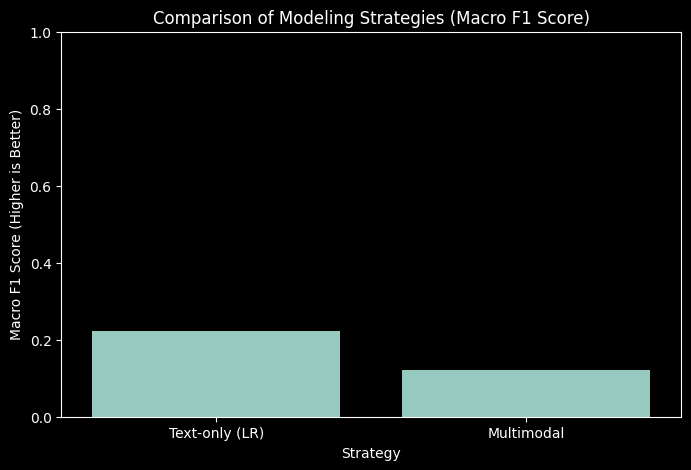


Conclusion: The Text-only (Logistic Regression) strategy performed as good as or better than the Multimodal one. This could indicate text features are highly dominant, or that fusion could be further optimized.


In [19]:
# --- 3. Compare the 2 Strategies ---
print("\n--- Comparison of Strategies ---")
print(f"Text-only Logistic Regression Macro F1 Score: {text_f1_macro:.4f}")
print(f"Multimodal Model Macro F1 Score: {multimodal_f1_macro:.4f}")

metrics_df = pd.DataFrame({
    'Strategy': ['Text-only (LR)', 'Multimodal'],
    'Macro F1 Score': [text_f1_macro, multimodal_f1_macro]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Strategy', y='Macro F1 Score', data=metrics_df)
plt.title('Comparison of Modeling Strategies (Macro F1 Score)')
plt.ylim(0, 1)
plt.ylabel('Macro F1 Score (Higher is Better)')
plt.show()

if multimodal_f1_macro > text_f1_macro:
    print("\nConclusion: The Multimodal strategy performed better, suggesting that incorporating image features adds value even with simpler text features.")
else:
    print("\nConclusion: The Text-only (Logistic Regression) strategy performed as good as or better than the Multimodal one. This could indicate text features are highly dominant, or that fusion could be further optimized.")


In [20]:
# --- Find the Last Convolutional Layer in MobileNetV2 ---
last_conv_layer_name = None
for layer in reversed(base_image_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("Could not find a Conv2D layer in base_image_model. Please check its layers.")

print(f"Identified last convolutional layer for Grad-CAM: {last_conv_layer_name}")


Identified last convolutional layer for Grad-CAM: Conv_1


Starting Grad-CAM analysis...

--- Analyzing Image 1/3 (Original Index: 296) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image File: image_1288891838_product_4086012947.png
True Label: 1280
Predicted Label: 1280 (Confidence: 13.69%)


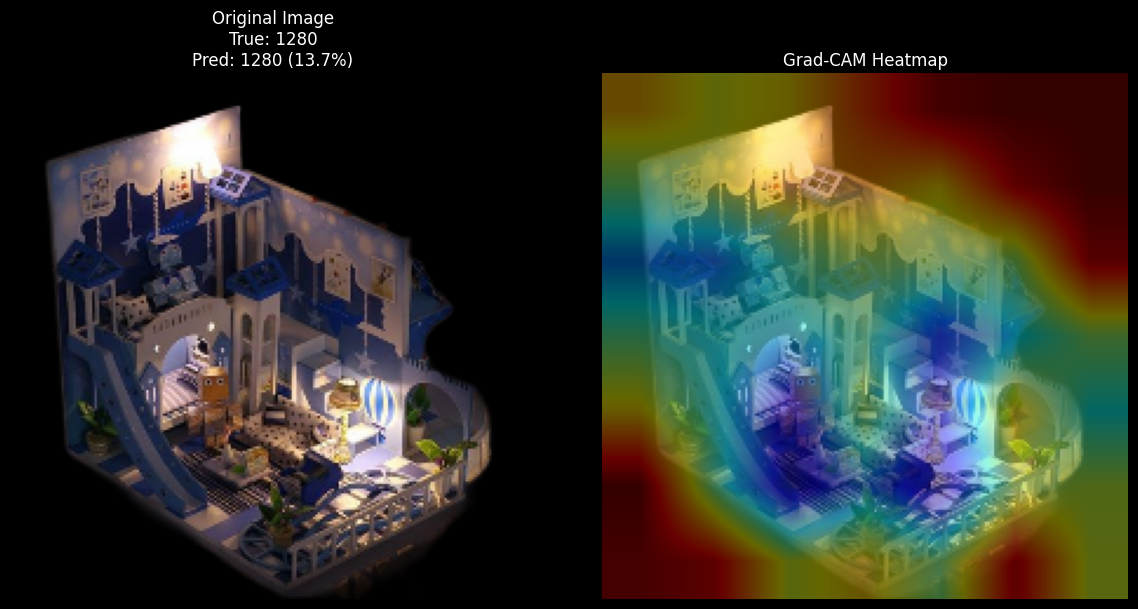


--- Analyzing Image 2/3 (Original Index: 238) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Image File: image_1295960377_product_4128438373.png
True Label: 2583
Predicted Label: 2583 (Confidence: 34.89%)


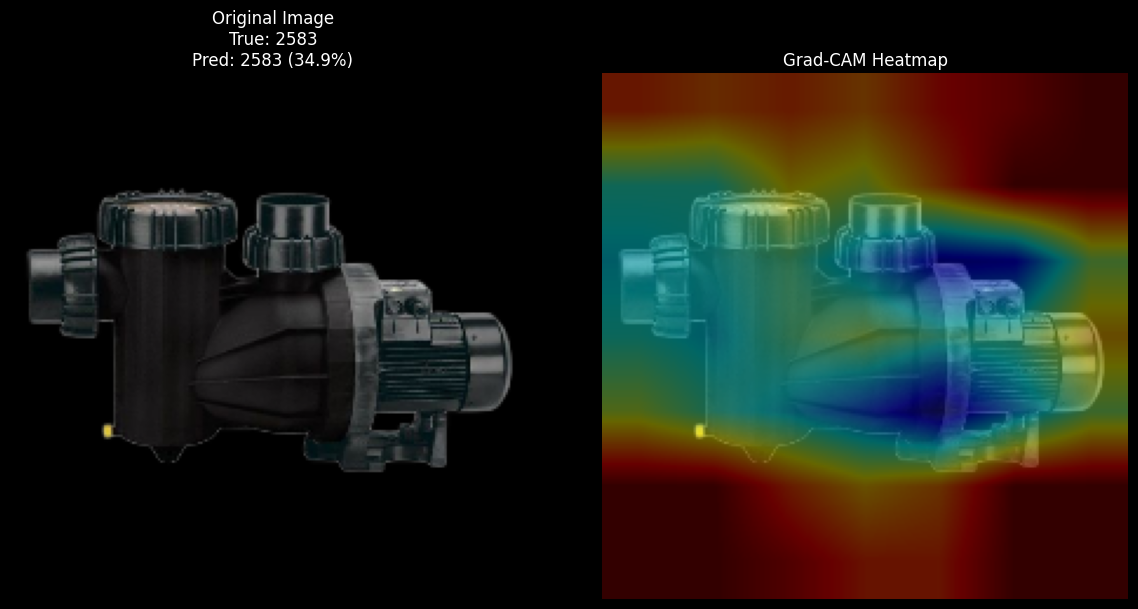


--- Analyzing Image 3/3 (Original Index: 162) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image File: image_941166404_product_205828886.png
True Label: 2280
Predicted Label: 2280 (Confidence: 25.49%)


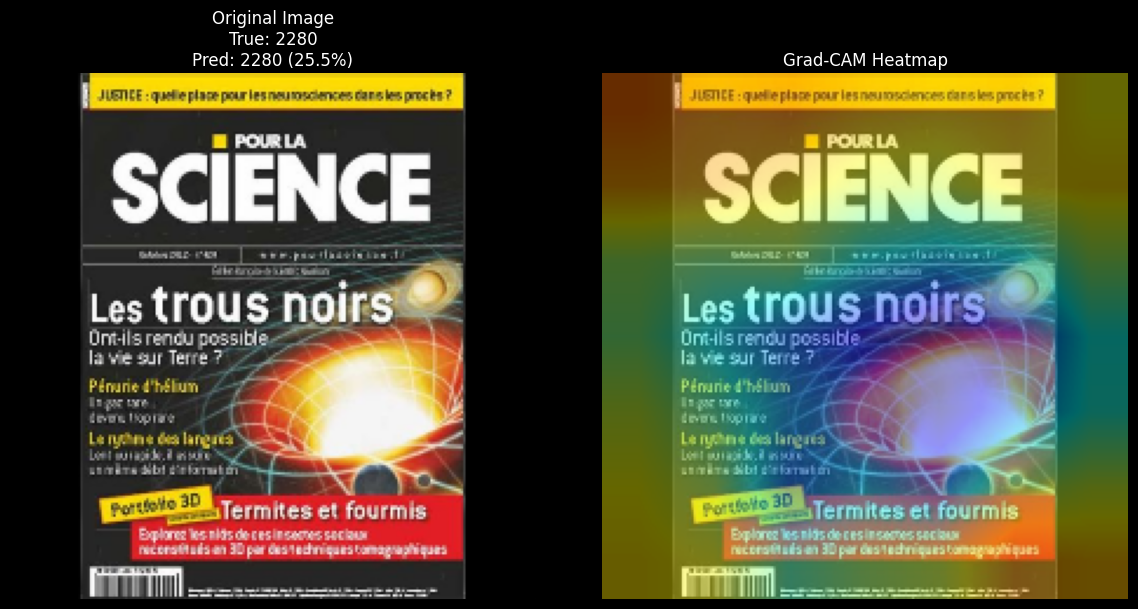

In [23]:
print("Starting Grad-CAM analysis...")
# Get random indices from training data
num_training_samples = len(X_train_split)
random_indices = random.sample(range(num_training_samples), min(3, num_training_samples))

for i, idx in enumerate(random_indices):
        print(f"\n--- Analyzing Image {i+1}/{len(random_indices)} (Original Index: {idx}) ---")

        # Get original image path
        product_id = X_train_split.iloc[idx]['productid']
        image_id = X_train_split.iloc[idx]['imageid']
        original_image_path = get_image_full_path(image_id, product_id, TRAIN_IMAGE_FOLDER_PATH)
    
        # Get the true label for this image
        true_label_one_hot = y_train_one_hot[idx]
        true_label_encoded = np.argmax(true_label_one_hot)
        true_category = label_encoder.inverse_transform([true_label_encoded])[0]
    
        # --- Prepare inputs for the multimodal model for this image ---
        # Need the pre-extracted features for prediction, and the raw image for Grad-CAM
        image_for_gradcam_array = load_and_preprocess_original_image_for_gradcam(original_image_path)
        # These are your pre-extracted features
        rgb_feat = loaded_train_rgb_features[idx]
        alpha_feat = loaded_train_alpha_features[idx]
        tfidf_vec = train_tfidf_features[idx].toarray().squeeze()
    
        # Reshape for model input (add batch dim if not already)
        rgb_feat_batch = tf.expand_dims(rgb_feat, axis=0)
        alpha_feat_batch = tf.expand_dims(alpha_feat, axis=0)
        tfidf_vec_batch = tf.expand_dims(tfidf_vec, axis=0)

        # Make prediction with the full multimodal model
        model_inputs_for_prediction = {
            'text_input_multi_tfidf': tfidf_vec_batch,
            'image_input_multi_rgb': rgb_feat_batch,
            'alpha_input_multi': alpha_feat_batch
        }
        # predictions = multimodal_model.predict(model_inputs_for_prediction, verbose=0)
        predictions = multimodal_model.predict(model_inputs_for_prediction)
        predicted_class_index = np.argmax(predictions[0])
        predicted_category = label_encoder.inverse_transform([predicted_class_index])[0]
        prediction_confidence = predictions[0][predicted_class_index] * 100

        print(f"Image File: {os.path.basename(original_image_path)}")
        print(f"True Label: {true_category}")
        print(f"Predicted Label: {predicted_category} (Confidence: {prediction_confidence:.2f}%)")

        # --- Generate Grad-CAM heatmap ---
        try:
            heatmap = make_gradcam_heatmap(
                img_array_raw=image_for_gradcam_array,
                multimodal_model=multimodal_model,
                base_image_model=base_image_model, # Ensure this is your actual MobileNetV2 instance
                target_conv_layer_name=last_conv_layer_name, # Pass the string name here.
                tfidf_feat_batch=tfidf_vec_batch,
                alpha_feat_batch=alpha_feat_batch,
                pred_index=predicted_class_index # This is correct for the class to explain
            )
        except Exception as e:
            print(f"Error generating Grad-CAM for this image: {e}")
            print("Skipping heatmap display for this image.")
            print(f"Warning: Grad-CAM heatmap generation failed (Error: {e}). Generating dummy heatmap.")
            heatmap = np.zeros(IMAGE_SIZE) # Create a black dummy heatmap

            
        # Display Grad-CAM result
        save_and_display_gradcam(
            original_image_path,
            heatmap,
            title=f"True: {true_category}\nPred: {predicted_category} ({prediction_confidence:.1f}%)"
        )


In [24]:
all_conv_layer_names = []
for layer in base_image_model.layers:
    # Check if the layer is a convolutional type and has a defined output tensor
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)) and hasattr(layer, 'output'):
        # Ensure its output is spatial (rank 4: batch, height, width, channels)
        # Using layer.output.shape which refers to the shape of the output tensor
        if len(layer.output.shape) == 4:
            # Exclude specific non-target layers (like BN or ReLU if they are separate layers,
            # or the input layer itself)
            if not layer.name.endswith('_BN') and \
               not layer.name.endswith('_relu') and \
               layer.name != base_image_model.input.name: # Exclude the input tensor's name
                all_conv_layer_names.append(layer.name)

if not all_conv_layer_names:
    raise ValueError("No suitable convolutional layers found in base_image_model for Grad-CAM. "
                     "Please check layer types and output shapes in base_image_model.summary().")

print(f"Identified {len(all_conv_layer_names)} convolutional layers for Grad-CAM:")
print(all_conv_layer_names)

Identified 52 convolutional layers for Grad-CAM:
['Conv1', 'expanded_conv_depthwise', 'expanded_conv_project', 'block_1_expand', 'block_1_depthwise', 'block_1_project', 'block_2_expand', 'block_2_depthwise', 'block_2_project', 'block_3_expand', 'block_3_depthwise', 'block_3_project', 'block_4_expand', 'block_4_depthwise', 'block_4_project', 'block_5_expand', 'block_5_depthwise', 'block_5_project', 'block_6_expand', 'block_6_depthwise', 'block_6_project', 'block_7_expand', 'block_7_depthwise', 'block_7_project', 'block_8_expand', 'block_8_depthwise', 'block_8_project', 'block_9_expand', 'block_9_depthwise', 'block_9_project', 'block_10_expand', 'block_10_depthwise', 'block_10_project', 'block_11_expand', 'block_11_depthwise', 'block_11_project', 'block_12_expand', 'block_12_depthwise', 'block_12_project', 'block_13_expand', 'block_13_depthwise', 'block_13_project', 'block_14_expand', 'block_14_depthwise', 'block_14_project', 'block_15_expand', 'block_15_depthwise', 'block_15_project', '

Starting Grad-CAM analysis for multiple layers...

--- Analyzing Image 1/1 (Original Index: 137) ---
Image File: image_1306587389_product_4168873908.png
True Label: 1560
Predicted Label: 1560 (Confidence: 24.06%)
  - Generating Grad-CAM for layer: Conv1
  - Generating Grad-CAM for layer: expanded_conv_depthwise
  - Generating Grad-CAM for layer: expanded_conv_project
  - Generating Grad-CAM for layer: block_1_expand
  - Generating Grad-CAM for layer: block_1_depthwise
  - Generating Grad-CAM for layer: block_1_project
  - Generating Grad-CAM for layer: block_2_expand
  - Generating Grad-CAM for layer: block_2_depthwise
  - Generating Grad-CAM for layer: block_2_project
  - Generating Grad-CAM for layer: block_3_expand
  - Generating Grad-CAM for layer: block_3_depthwise
  - Generating Grad-CAM for layer: block_3_project
  - Generating Grad-CAM for layer: block_4_expand
  - Generating Grad-CAM for layer: block_4_depthwise
  - Generating Grad-CAM for layer: block_4_project
  - Generating

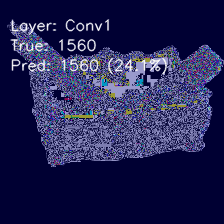


Grad-CAM analysis complete for selected images across all relevant layers.


In [27]:
from IPython.display import Image, display
print("Starting Grad-CAM analysis for multiple layers...")
num_training_samples = len(X_train_split)
random_indices = random.sample(range(num_training_samples), min(1, num_training_samples)) # Select 10 random images

gradcam_animation_frames = []
gif_filename = "gradcam_animation_first_image.gif"

for i, idx in enumerate(random_indices):
    # We will create a GIF only for the first selected image for demonstration
    is_first_image = (i == 0)

    print(f"\n--- Analyzing Image {i+1}/{len(random_indices)} (Original Index: {idx}) ---")

    product_id = X_train_split.iloc[idx]['productid']
    image_id = X_train_split.iloc[idx]['imageid']
    original_image_path = get_image_full_path(image_id, product_id, TRAIN_IMAGE_FOLDER_PATH)

    true_label_one_hot = y_train_one_hot[idx]
    true_label_encoded = np.argmax(true_label_one_hot)
    true_category = label_encoder.inverse_transform([true_label_encoded])[0]

    image_for_gradcam_array = load_and_preprocess_original_image_for_gradcam(original_image_path)

    rgb_feat = loaded_train_rgb_features[idx]
    alpha_feat = loaded_train_alpha_features[idx]
    tfidf_vec = train_tfidf_features[idx].toarray().squeeze()

    rgb_feat_batch = tf.expand_dims(rgb_feat, axis=0)
    alpha_feat_batch = tf.expand_dims(alpha_feat, axis=0)
    tfidf_vec_batch = tf.expand_dims(tfidf_vec, axis=0)

    model_inputs_for_prediction = {
        'text_input_multi_tfidf': tfidf_vec_batch,
        'image_input_multi_rgb': rgb_feat_batch,
        'alpha_input_multi': alpha_feat_batch
    }
    predictions = multimodal_model.predict(model_inputs_for_prediction, verbose=0)
    predicted_class_index = np.argmax(predictions[0])
    predicted_category = label_encoder.inverse_transform([predicted_class_index])[0]
    prediction_confidence = predictions[0][predicted_class_index] * 100

    print(f"Image File: {os.path.basename(original_image_path)}")
    print(f"True Label: {true_category}")
    print(f"Predicted Label: {predicted_category} (Confidence: {prediction_confidence:.2f}%)")

    # --- Loop through all identified convolutional layers for this image ---
    for layer_name in all_conv_layer_names:
        print(f"  - Generating Grad-CAM for layer: {layer_name}")
        try:
            heatmap = make_gradcam_heatmap(
                img_array_raw=image_for_gradcam_array,
                multimodal_model=multimodal_model,
                base_image_model=base_image_model,
                target_conv_layer_name=layer_name,
                tfidf_feat_batch=tfidf_vec_batch,
                alpha_feat_batch=alpha_feat_batch,
                pred_index=predicted_class_index
            )
            
            # Get the superimposed image array for display and GIF
            current_superimposed_img = superimpose_gradcam_on_image(
                original_image_path,
                heatmap,
                alpha=0.4
            )

            # Add text overlay to the frame for better GIF clarity
            # Create a copy to avoid modifying the original `current_superimposed_img` if it's used elsewhere
            frame_with_text = current_superimposed_img.copy()
            text_info = f"Layer: {layer_name}\nTrue: {true_category}\nPred: {predicted_category} ({prediction_confidence:.1f}%)"
            
            # Split text into lines for multi-line display
            text_lines = text_info.split('\n')
            y0, dy = 30, 20 # Starting Y-coordinate and line height
            for k, line in enumerate(text_lines):
                cv2.putText(frame_with_text, line, (10, y0 + k*dy), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            
            if is_first_image:
                gradcam_animation_frames.append(frame_with_text)

            # fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            # original_masked_display = np.uint8(image_for_gradcam_array[0].numpy() * 255)
            # axes[0].imshow(original_masked_display)
            # axes[0].set_title(f"Original Masked Image\nTrue: {true_category}\nPred: {predicted_category} ({prediction_confidence:.1f}%)")
            # axes[0].axis('off')

            # axes[1].imshow(current_superimposed_img) # The superimposed image
            # axes[1].set_title(f"Grad-CAM Heatmap\nLayer: {layer_name}")
            # axes[1].axis('off')
            # plt.tight_layout()
            # plt.show()

        except Exception as e:
            print(f"  Error generating Grad-CAM for layer {layer_name}: {e}")
            print(f"  Skipping heatmap display for layer {layer_name} for this image.")
    
    # After processing all layers for the first image, create the GIF
    if is_first_image and gradcam_animation_frames:
        print(f"\nCreating GIF: {gif_filename} with {len(gradcam_animation_frames)} frames...")
        try:
            # `duration` is in milliseconds per frame. `loop=0` means infinite loop.
            imageio.mimsave(gif_filename, gradcam_animation_frames, loop=0, duration=2000)
            print(f"GIF '{gif_filename}' created successfully for the first image.")
            display(Image(filename=gif_filename))
        except Exception as e:
            print(f"Error creating GIF: {e}")
    
print("\nGrad-CAM analysis complete for selected images across all relevant layers.")